In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import constants
from scipy import signal
%matplotlib inline

import scipy.integrate as integrate
import random
import matplotlib.colors as colors 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
'''defining constants'''
#working in units of s
m_solar = 1.98840987e30 * constants.G / constants.c **3#in seconds

'''Input Parameters'''
m_chirp = 1e6 * m_solar #obersved chirp mass(m1=m2)
f_min = 1e-4 #min observed frequency
f_max = 1e-1
phi_c = 0 #set initial phase
D_L = 1e9 * constants.parsec/constants.c #1Gpc
print(D_L)
print(m_chirp)
print(m_solar)

# theta_l_bar = np.pi/5
# phi_l_bar = np.pi/11

# theta_s_bar = np.pi * (2/7)
# phi_s_bar = np.pi * (7/12)

phi_0_bar = 0 #this is given by LISA engineers, chosen as 0 for time being

1.02927125054339e+17
4.925490945912125
4.925490945912125e-06


In [3]:
### GW signal ###

def frequency(t, t_c, m_chirp):
    ''' Calculate the frequency as a function of time '''
    return (((t_c - t)/5)**(-3/8))/(8*np.pi*(m_chirp**(5/8)))
    
def phase_function_of_t(t, t_c, m_chirp):
    ''' Calculate the phase as a funciton of time '''
    return -2*((t_c-t)/(5*m_chirp))**(5/8) + phi_c

def phase_function_of_f(f, m_chirp):
    ''' Calculate the phase as a function of frequency '''
    return  phi_c - 2*(8*np.pi*m_chirp*f)**(-5/3)

def F_p(theta_s, phi_s, psi_s):
    ''' Calculate the plus polarisation from inpute angle parameters '''
    return ( (1/2) * (1 + np.cos(theta_s)**2) * np.cos(2*phi_s) * np.cos(2*psi_s) ) \
    - ( np.cos(theta_s) * np.sin(2*phi_s) * np.sin(2*psi_s) )

def F_c(theta_s, phi_s, psi_s): 
    ''' Calculate the plus polarisation from inpute angle parameters '''
    return ( (1/2) * (1 + np.cos(theta_s)**2) * np.cos(2*phi_s) * np.sin(2*psi_s) ) \
+ ( np.cos(theta_s) * np.sin(2*phi_s) * np.cos(2*psi_s) )
    
def phi_func_t_bar(t):
    ''' Calculate phi as a function of t '''
    return phi_0_bar + (2*np.pi*t/constants.year)

def theta_s_func_t(t, theta_s_bar, phi_s_bar):
    ''' Calculate theta_s as a function of t '''
    return np.arccos( 0.5*np.cos(theta_s_bar) - (np.sqrt(3)/2)*np.sin(theta_s_bar)*np.cos(phi_func_t_bar(t) - phi_s_bar) )
    

def phi_s_func_t(t, theta_s_bar, phi_s_bar):
    ''' Calculate phi_s as a function of t '''
    detector_number = 1 #will be 2 when we add other arm
    alpha_1 = (2*np.pi*t/constants.year) - np.pi/12 - ((detector_number - 1)*np.pi/3)

    return alpha_1 + (np.pi/12) + np.arctan( (np.sqrt(3) * np.cos(theta_s_bar) + np.sin(theta_s_bar)*np.cos(phi_func_t_bar(t) - phi_s_bar))/(2*np.sin(theta_s_bar)*np.sin(phi_func_t_bar(t) - phi_s_bar)) )


def psi_s_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    ''' Calculate psi as a function of t '''
    L_dot_z = ( (1/2)*np.cos(theta_l_bar) ) - ( (np.sqrt(3)/2)*np.sin(theta_l_bar)*np.cos(phi_func_t_bar(t) - phi_l_bar) )

    L_dot_n = ( ( np.cos(theta_l_bar)*np.cos(theta_s_bar) ) + ( np.sin(theta_l_bar)*np.sin(theta_s_bar)*np.cos(phi_l_bar - phi_s_bar) ) )

    z_dot_n = np.cos(theta_s_func_t(t, theta_s_bar, phi_s_bar)) #e.g z dot n = cos(theta_s(t))

    n_dot_L_cross_z = (1/2) * np.sin(theta_l_bar) * np.sin(theta_s_bar) * np.sin(phi_l_bar - phi_s_bar) \
    - (np.sqrt(3)/2) * np.cos(phi_func_t_bar(t)) * ( (np.cos(theta_l_bar)*np.sin(theta_s_bar)*np.sin(phi_s_bar)) - (np.cos(theta_s_bar)*np.sin(theta_l_bar)*np.sin(phi_l_bar)) ) \
    - (np.sqrt(3)/2) * np.sin(phi_func_t_bar(t)) * ( (np.cos(theta_s_bar)*np.sin(theta_l_bar)*np.cos(phi_l_bar)) - (np.cos(theta_l_bar)*np.sin(theta_s_bar)*np.cos(phi_s_bar)))

    return np.arctan( (L_dot_z - (L_dot_n*z_dot_n))/n_dot_L_cross_z)


def A_func_t(t, t_c, m_chirp, D_L):
    ''' Calculate gravitational wave amplitdue as a function of t '''
    return 2/D_L * m_chirp**(5/3) * (np.pi*frequency(t, t_c, m_chirp))**(2/3) #waveform amplitude


def A_p_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    ''' Calculate polarisation amplitude as a function of t '''
    F_plus_func_t = F_p(theta_s_func_t(t, theta_s_bar, phi_s_bar), phi_s_func_t(t, theta_s_bar, phi_s_bar), psi_s_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))
    #print(F_plus_func_t)
    F_cross_func_t = F_c(theta_s_func_t(t, theta_s_bar, phi_s_bar), phi_s_func_t(t, theta_s_bar, phi_s_bar), psi_s_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))
    
    L_dot_n = ( ( np.cos(theta_l_bar)*np.cos(theta_s_bar) ) + ( np.sin(theta_l_bar)*np.sin(theta_s_bar)*np.cos(phi_l_bar - phi_s_bar) ) )
    iota = np.arccos(L_dot_n)

    return (np.sqrt(3)/2) * ( (F_plus_func_t**2 * (1 + np.cos(iota)**2)**2) + (F_cross_func_t**2 * 4 * np.cos(iota)**2) )**(1/2)


def phi_p_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    ''' Clculate polarisation phase as a function of t '''
    F_plus_func_t = F_p(theta_s_func_t(t, theta_s_bar, phi_s_bar), phi_s_func_t(t, theta_s_bar, phi_s_bar), psi_s_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))

    F_cross_func_t = F_c(theta_s_func_t(t, theta_s_bar, phi_s_bar), phi_s_func_t(t, theta_s_bar, phi_s_bar), psi_s_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))
    
    L_dot_n = ( ( np.cos(theta_l_bar)*np.cos(theta_s_bar) ) + ( np.sin(theta_l_bar)*np.sin(theta_s_bar)*np.cos(phi_l_bar - phi_s_bar) ) )
    iota = np.arccos(L_dot_n)
    
    return np.arctan2( (2*np.cos(iota)*F_cross_func_t), ((1 + np.cos(iota)**2)*F_plus_func_t) )


def phi_d_func_t(t, t_c, m_chirp, theta_s_bar, phi_s_bar):
    ''' Calculate Doppler phase as a function of time '''
    R = constants.astronomical_unit/constants.c
    
    return 2 * np.pi * frequency(t, t_c, m_chirp) * R * np.sin(theta_s_bar) * np.cos(phi_func_t_bar(t) - phi_s_bar)

def h_func_t_piecewise(t, t_c, m_chirp, t_isco, D_L, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    ''' Calculate dimesnionless strain as a function of time up to time of innermost stable circular orbit''' 
    return np.piecewise(t, [t < t_isco, t > t_isco], [lambda t: A_func_t(t, t_c, m_chirp, D_L) * A_p_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar) * np.cos(phase_function_of_t(t, t_c, m_chirp) \
             + phi_p_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar) +  phi_d_func_t(t, t_c, m_chirp, theta_s_bar, phi_s_bar)), 0])

def frequency_piecewise(t, t_c, m_chirp, t_isco):
    ''' Calculate frequency as a function of time up to t_isco '''
    return np.piecewise(t, [t < t_isco, t > t_isco], [lambda t: frequency(t, t_c, m_chirp), 0])

### Noise ### 

def P_OMS(f):
    ''' Single test mass acceleration noise as a function of f '''
    return 1.5e-11 ** 2 * (1 + (2e-3 / f) ** 4)

def P_acc(f):
    ''' Single-link optical metrology noise '''
    return 3e-15 ** 2 * (1 + (0.4e-3 / f) ** 2) * (1 + (f / 8e-3) ** 4)

def S_c(f):
    ''' Galactic confusion noise as a function of f '''
    A = 9e-45
    alpha = 0.171
    beta = 292
    kappa = 1020
    gamma = 1680
    f_k = 0.00215

    return A * f ** (-7 / 3) * np.exp(-(f ** alpha) + beta * f * np.sin(kappa * f)) * (1 + np.tanh(gamma * (f_k - f)))

def S_n(f): 
    ''' LISA sensitivity curve as a function of f '''
    return S_c(f) + 10 / (3 * 2.5e9 ** 2) * (P_OMS(f) + 2 * (1 + np.cos(f / 19.09e-3) ** 2) * P_acc(f) / (2 * np.pi * f) ** 4) * (1 + (6 / 10) * (f / 19.09e-3) ** 2)


def get_noise(f):
    ''' Draw noise by smapling a stationary Gaussian distribution of the complete sensitivty curve '''
    variance = np.ones((int(N_t / N_perseg), len(f))) * S_n(f).T * delta_f
    imag = np.exp(1j * np.random.uniform(0, 2 * np.pi, variance.shape))
    noise = np.random.normal(0, np.sqrt(variance)) * imag

    return noise

### SNR ###

def t_func_f(f, t_c, m_chirp):
    ''' Calculate time as a function of f '''
    return t_c - 5*(8*np.pi*f)**(-8/3) * m_chirp**(-5/3)

def FT_h_func_f_squared(f, t_c, m_chirp, D_L, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    ''' Analytic expression for Fourier trasformed dimensionless strain sqaured as a function of f '''
    return np.abs(A_p_func_t(t_func_f(f, t_c, m_chirp), theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar) * np.sqrt(5/96) * np.pi**(-2/3) * m_chirp**(5/6) * f**(-7/6) * (1/D_L) * np.exp(1j*(phase_function_of_f(f, m_chirp) - phi_p_func_t(t_func_f(f, t_c, m_chirp), theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar) - phi_d_func_t(t_func_f(f, t_c, m_chirp), t_c, m_chirp, theta_s_bar, phi_s_bar))))**2

def integrand(f, t_c, m_chirp, D_L, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    ''' Integrand for SNR calculation '''
    I = (FT_h_func_f_squared(f, t_c, m_chirp, D_L, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar)) / S_n(f)
    return I

In [4]:
#Code for second detector by changing phi_s(t) by -pi/4

def A_p_func_t2(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    
    F_plus_func_t = F_p(theta_s_func_t(t, theta_s_bar, phi_s_bar), phi_s_func_t(t, theta_s_bar, phi_s_bar) - np.pi/4, psi_s_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))
    #print(F_plus_func_t)
    F_cross_func_t = F_c(theta_s_func_t(t, theta_s_bar, phi_s_bar), phi_s_func_t(t, theta_s_bar, phi_s_bar) - np.pi/4, psi_s_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))
    
    L_dot_n = ( ( np.cos(theta_l_bar)*np.cos(theta_s_bar) ) + ( np.sin(theta_l_bar)*np.sin(theta_s_bar)*np.cos(phi_l_bar - phi_s_bar) ) )
    iota = np.arccos(L_dot_n)

    return (np.sqrt(3)/2) * ( (F_plus_func_t**2 * (1 + np.cos(iota)**2)**2) + (F_cross_func_t**2 * 4 * np.cos(iota)**2) )**(1/2)


def phi_p_func_t2(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    
    F_plus_func_t = F_p(theta_s_func_t(t, theta_s_bar, phi_s_bar), phi_s_func_t(t, theta_s_bar, phi_s_bar) - np.pi/4, psi_s_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))

    F_cross_func_t = F_c(theta_s_func_t(t, theta_s_bar, phi_s_bar), phi_s_func_t(t, theta_s_bar, phi_s_bar) - np.pi/4, psi_s_func_t(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))
    
    L_dot_n = ( ( np.cos(theta_l_bar)*np.cos(theta_s_bar) ) + ( np.sin(theta_l_bar)*np.sin(theta_s_bar)*np.cos(phi_l_bar - phi_s_bar) ) )
    iota = np.arccos(L_dot_n)
    
    return np.arctan2( (2*np.cos(iota)*F_cross_func_t), ((1 + np.cos(iota)**2)*F_plus_func_t) )

def h_func_t_piecewise2(t, t_c, m_chirp, t_isco, D_L, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    return np.piecewise(t, [t < t_isco, t > t_isco], [lambda t: A_func_t(t, t_c, m_chirp, D_L) * A_p_func_t2(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar) * np.cos(phase_function_of_t(t, t_c, m_chirp) \
             + phi_p_func_t2(t, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar) +  phi_d_func_t(t, t_c, m_chirp, theta_s_bar, phi_s_bar)), 0])

def FT_h_func_f_squared2(f, t_c, m_chirp, D_L, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    return np.abs(A_p_func_t2(t_func_f(f, t_c, m_chirp), theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar) * np.sqrt(5/96) * np.pi**(-2/3) * m_chirp**(5/6) * f**(-7/6) * (1/D_L) * np.exp(1j*(phase_function_of_f(f, m_chirp) - phi_p_func_t2(t_func_f(f, t_c, m_chirp), theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar) - phi_d_func_t(t_func_f(f, t_c, m_chirp), t_c, m_chirp, theta_s_bar, phi_s_bar))))**2

def integrand2(f, t_c, m_chirp, D_L, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar):
    I = (FT_h_func_f_squared2(f, t_c, m_chirp, D_L, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar)) / S_n(f)
    return I

#phi_D(t) remains the same as before



def fourier_transform(signal, N_perseg, delta_t, noise):
    ''' Spectogram generator '''
    freqs_signal, times_signal, spec_signal = scipy.signal.stft(signal, fs=1, window='hann', nperseg= int(N_perseg), noverlap=0)
    #window=('tukey', 0.25)
    #window = 'hann'
    times_signal = times_signal * delta_t
    freqs_signal = freqs_signal/ delta_t    
    
    count = 0
    for value in freqs_signal:
        if value < 1e-4:
            count += 1

    freqs_signal = np.delete(freqs_signal, np.s_[:count])
    times_signal = np.delete(times_signal, 0, 0)
    spec_signal = np.delete(spec_signal, np.s_[:count], 0)
    spec_signal = np.delete(spec_signal, 0, 1)
    
    delta_rows = np.abs(len(noise) - len(spec_signal))
    scaled_spec_signal = np.append(spec_signal, np.zeros((delta_rows, len(spec_signal[0])))).reshape(noise.shape)
    
    return scaled_spec_signal

def artifact_model(t, t_c):
    ''' Glitch model '''
    A_0 = np.array(np.random.uniform(0.5e-18, 1.5e-18)) 
    phi_0 = np.array(np.random.uniform(0, np.pi))
    f_glitch = np.array(np.random.uniform(1e-5, 1e-1))
    w = 2 * np.pi * f_glitch
    tau_glitch = 1/f_glitch
    scale =  np.array(np.random.uniform(1e3, 1e5))
    output = A_0 * np.sin((w*t) + phi_0) * np.exp(-(t-t_c)**2/(2*np.pi*tau_glitch**2)/scale) 

    return output

def t_c_max(f_min, m_chirp, T_obs):
    ''' Maximum t_c value for a particular chirp mass that ensures the event oasses through the LISA frequency band '''
    return 5 * (8*np.pi*f_min)**(-8/3) * m_chirp**(-5/3) + T_obs


In [5]:
# Binary Parameters
m_chirp_min = np.log10(m_chirp/10) 
m_chirp_max = np.log10(m_chirp*10)

D_L_min = np.log10(D_L)
D_L_max = np.log10(D_L*10)

# Sampling Parameters
T_obs = int(1e6)
delta_t = 100
N_t = T_obs / delta_t #number of times
N_perseg = 1e2
T_seg = N_perseg * delta_t
delta_f = 1 / T_seg
N_f = (f_max - f_min) / delta_f + 1

The following code is for the generation of training data and the training of the neural network itslef. Loading a trained network can be done to bypass this section.

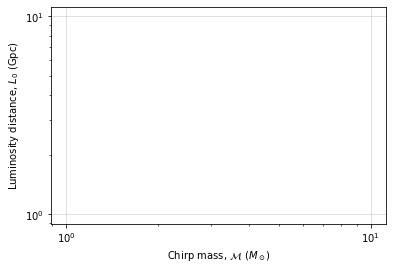

 coalescences observed in time T_obs is 4952 or 49.83%
 Number of signals with SNR > threshold of 200 is 0 or 0.00%
(20000, 1000, 100) --- (20000,)
CPU times: user 10min 27s, sys: 14 s, total: 10min 41s
Wall time: 10min 43s


In [6]:
%%time
def data_generator(n_masses = 100, percentage_chance = 0.10):
    ''' Generates data set of features and labels'''
    features = []
    labels = []

    signal_sig = []
    signal2_sig = []
    artifact_sig = []

    t = np.linspace(delta_t, T_obs, int(N_t))

    coalescences_observed = 0
    signals_detected = 0
    SNR_thresh = 200

    SNRs = []
    chirp_masses = []
    luminosity_distances = []
    
    for i in range(n_masses):
        m_chirp_rand = 10**np.random.uniform(m_chirp_min, m_chirp_max)
        D_L_rand = 10**np.random.uniform(D_L_min, D_L_max)
        
        theta_l_bar = random.uniform(0, 2*np.pi)
        phi_l_bar =  random.uniform(0, 2*np.pi)
        theta_s_bar =  random.uniform(0, 2*np.pi)
        phi_s_bar =  random.uniform(0, 2*np.pi)
        
        t_c_max_val = t_c_max(f_min, m_chirp_rand, T_obs)
        
        #t_c = random.uniform(T_seg, T_obs)
        if random.randint(0, 1) == 0: #half values in T_obs
            t_c = random.uniform(T_seg, T_obs)
        else:
            t_c = random.uniform(T_obs, t_c_max_val)
        
        f_isco = 1/(np.pi * 6**(3/2) * 2**(6/5) * m_chirp_rand)
        t_isco = t_c - 5 * (8*np.pi*f_isco)**(-8/3) * m_chirp_rand**(-5/3)
        f_noise = np.linspace(f_min, f_max, int(N_f)) 
        
        #integration limits
        lower = np.maximum(f_min, frequency(0, t_c, m_chirp_rand))
        if t_isco > T_obs:
            upper = frequency(T_obs, t_c, m_chirp_rand)
        else:
            upper = f_isco

        noise = get_noise(f_noise).T #noise drawn here, as only 1 of 4 of options below occur each iteration
        
        random_val = random.randint(0,3)
        if random_val == 0: #ch1 signal:
            chirp_masses.append(m_chirp_rand/m_solar)
            luminosity_distances.append(D_L_rand/(1e9*constants.parsec/constants.c))

            if upper < lower: #this should not happen if t_c is selected up to t_c_max
                print('Stop')
                SNR = 0
            else:
                SNR = np.sqrt(4*integrate.quad(integrand, lower, upper, args = (t_c, m_chirp_rand, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))[0])
            SNRs.append(SNR)
            # SNR = np.sqrt(4*integrate.quad(integrand, f_min, f_max, args = (t_c, m_chirp_rand, D_L_rand))[0])
            # SNRs.append(SNR)
#             if SNR > SNR_thresh:
#                 signals_detected += 1
#                 plt.scatter(m_chirp_rand/m_solar, D_L_rand/(1e9*constants.parsec/constants.c))
#             else:
#                 plt.scatter(m_chirp_rand/m_solar, D_L_rand/(1e9*constants.parsec/constants.c), facecolors='none', edgecolors = 'black')

            if t_c < T_obs:
                coalescences_observed += 1

            signal = h_func_t_piecewise(t, t_c, m_chirp_rand, t_isco, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar)
            signal_sig.append(signal) #append signal to plot later
            ft_signal = fourier_transform(signal, N_perseg, delta_t, noise)
            labels.append(0)
            
            if random.random() < percentage_chance: #add an artifact to the signal
                #print('Ch1 signal + artifact')
                artifact = artifact_model(t, t_c)
                ft_artifact = fourier_transform(artifact, N_perseg, delta_t, noise)
                ft_signal_2part = np.add(ft_signal, noise)
                scaled_ft_signal_3part = np.abs(np.add(ft_signal_2part, ft_artifact))/ np.amax(np.abs(np.add(ft_signal_2part, ft_artifact)))
                features.append(scaled_ft_signal_3part**2)
            else: #just signal
                scaled_ft_signal = np.abs(np.add(ft_signal, noise))/ np.amax(np.abs(np.add(ft_signal, noise)))
                features.append(scaled_ft_signal**2)

        elif random_val == 1:#ch2 signal
            chirp_masses.append(m_chirp_rand/m_solar)
            luminosity_distances.append(D_L_rand/(1e9*constants.parsec/constants.c))

            if upper < lower: #this should not happen if t_c is selected up to t_c_max
                print('Stop')
                SNR = 0
            else:
                SNR = np.sqrt(4*integrate.quad(integrand, lower, upper, args = (t_c, m_chirp_rand, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))[0])
            SNRs.append(SNR)
            # SNR = np.sqrt(4*integrate.quad(integrand, f_min, f_max, args = (t_c, m_chirp_rand, D_L_rand))[0])
            # SNRs.append(SNR)
#             if SNR > SNR_thresh:
#                 signals_detected += 1
#                 plt.scatter(m_chirp_rand/m_solar, D_L_rand/(1e9*constants.parsec/constants.c))
#             else:
#                 plt.scatter(m_chirp_rand/m_solar, D_L_rand/(1e9*constants.parsec/constants.c), facecolors='none', edgecolors = 'black')

            if t_c < T_obs:
                coalescences_observed += 1

            signal2 = h_func_t_piecewise2(t, t_c, m_chirp_rand, t_isco, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar)
            signal2_sig.append(signal2)
            ft_signal2 = fourier_transform(signal2, N_perseg, delta_t, noise)
            labels.append(0)
            
            if random.random() < percentage_chance: 
                artifact = artifact_model(t, t_c)
                ft_artifact = fourier_transform(artifact, N_perseg, delta_t, noise)
                ft_signal2_2part = np.add(ft_signal2, noise)
                scaled_ft_signal2_3part = np.abs(np.add(ft_signal2_2part, ft_artifact))/ np.amax(np.abs(np.add(ft_signal2_2part, ft_artifact)))
                features.append(scaled_ft_signal2_3part**2)
            else:
                scaled_ft_signal2 = np.abs(np.add(ft_signal2, noise))/ np.amax(np.abs(np.add(ft_signal2, noise)))
                features.append(scaled_ft_signal2**2)

        else:
            labels.append(1) #no signal
            if random.random() < percentage_chance:
                artifact = artifact_model(t, t_c)
                artifact_sig.append(artifact)
                ft_artifact = fourier_transform(artifact, N_perseg, delta_t, noise)
                scaled_ft_artifact = np.abs(np.add(ft_artifact, noise))/ np.amax(np.abs(np.add(ft_artifact, noise)))
                features.append(scaled_ft_artifact**2)
            else: #noise
                scaled_noise = np.abs(noise) / np.amax(np.abs(noise))
                features.append(scaled_noise**2) 
            
    ### Plotting ## 
    plt.xlabel(r"Chirp mass, $\mathcal{M}$ $(M_\odot)$")
    plt.ylabel(r"Luminosity distance, $L_0$ (Gpc)")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(alpha = 0.5)
    plt.show()

    features = np.array(features)
    labels = np.array(labels)

    print(f' coalescences observed in time T_obs is {coalescences_observed} or {coalescences_observed*100/len(SNRs):.2f}%')
    print(f' Number of signals with SNR > threshold of {SNR_thresh} is {signals_detected} or {signals_detected*100/len(SNRs):.2f}%')
 
    print(np.shape(features), '---', np.shape(labels))
    return features, labels, chirp_masses, luminosity_distances, SNRs, signal_sig, signal2_sig, artifact_sig

features, labels, chirp_masses, luminosity_distances, SNRs, signal_sig, signal2_sig, artifact_sig = data_generator(20000, 0.5) #change number of data points generated here (40000 used for the report)

In [7]:
import matplotlib

In [8]:
def distribution_histogram(data):
    hx, hy, _ = plt.hist(data, bins=50, color="lightblue")
    plt.grid(alpha = 0.5)
    plt.xlabel(r"Chirp mass, $\mathcal{M}$ $(M_\odot)$")
    plt.ylabel('Frequency')
    #plt.ylim(0.0,max(hx)+0.05)
    plt.xscale('log')
    plt.show()

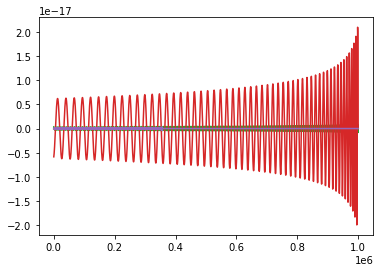

In [9]:
#plotting some example waveforms
t = np.linspace(delta_t, T_obs, int(N_t))
for i in range(5):
    plt.plot(t, signal_sig[i])

In [10]:
print(f'Average SNR is {sum(i for i in SNRs)/len(SNRs):.2f}')
print(f' Max SNR is {np.amax(SNRs):.2f}')
print(f' Min SNR is {np.amin(SNRs):.2f}')

Average SNR is 467.30
 Max SNR is 8015.04
 Min SNR is 0.01


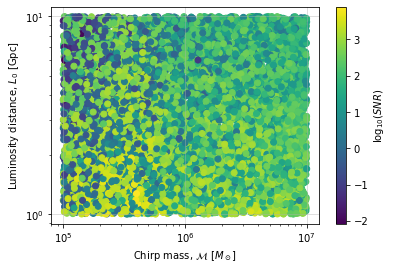

In [11]:
plt.scatter(chirp_masses, luminosity_distances, c=np.log10(SNRs))
plt.xlabel(r"Chirp mass, $\mathcal{M}$ $[M_\odot]$")
plt.ylabel(r"Luminosity distance, $L_0$ [Gpc]")
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label = r"$\log_{10}(SNR)$")
plt.grid(alpha = 0.5)
plt.savefig('mass_luminsoty_snr_colourbar')
plt.show()

In [12]:
def image_resizer(image): #rescale input features to reduce computation time
    images_expand_dims = np.expand_dims(image, axis = 3)
    print(images_expand_dims.shape)
    images_resize = tf.image.resize(images_expand_dims, [500, 50], method='area', preserve_aspect_ratio=False,
        antialias=False, name=None)
    return images_resize

In [13]:
features = image_resizer(features) #hash to not resize

(20000, 1000, 100, 1)


In [14]:
#here data is plit into the three data subsets for the NN
train_split = 0.80
val_split = 0.10
test_split = 0.10

train_features = features[:int(len(features)*train_split)]
train_labels = labels[:int(len(labels)*train_split)]

validation_features = features[int(len(features)*train_split):int(len(features)*(train_split+val_split))]
validation_labels = labels[int(len(features)*train_split):int(len(features)*(train_split+val_split))]

test_features = features[int(len(features)*(train_split + val_split)):]#train_split + val_split = 1 - test_split
test_labels = labels[int(len(features)*(train_split + val_split)):]

test_chirp_masses = chirp_masses[int(len(chirp_masses)*(train_split + val_split)):]
test_luminosity_distances = luminosity_distances[int(len(luminosity_distances)*(train_split + val_split)):]
test_SNRs = SNRs[int(len(SNRs)*(train_split + val_split)):]

print(train_labels)
print(len(train_labels))
print(len(validation_labels))
print(test_labels)

[0 1 1 ... 1 0 1]
16000
2000
[0 1 0 ... 0 1 0]


In [15]:
# import regularizer
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2

from tensorflow.keras.callbacks import TensorBoard

In [16]:
%%time
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(500, 50)), #architecture of the network 
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(25, activation='relu'),#
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), #defined initial learning rate and optimzer and loss function
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

              metrics=['accuracy'])


model.summary()
def scheduler(epoch, lr): #reduce learning rate exponetially to help convergence
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.05)
    

history = model.fit(train_features, train_labels, batch_size=20, #number of epochs and matchsize drastically effect the training time (100 epochs used for the report)
        epochs=100, 
        callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)
                    ],
                     validation_data=(validation_features,  validation_labels), shuffle = True) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25000)             0         
                                                                 
 dropout (Dropout)           (None, 25000)             0         
                                                                 
 dense (Dense)               (None, 250)               6250250   
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               25100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 25)                2

/rds/homes/l/lga834/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


800/800 [==============================] - 10s 12ms/step - loss: 0.6032 - accuracy: 0.6555 - val_loss: 0.5681 - val_accuracy: 0.6845 - lr: 0.0100
Epoch 2/100
800/800 [==============================] - 9s 11ms/step - loss: 0.5879 - accuracy: 0.6756 - val_loss: 0.5878 - val_accuracy: 0.6895 - lr: 0.0100
Epoch 3/100
800/800 [==============================] - 8s 10ms/step - loss: 0.6140 - accuracy: 0.6741 - val_loss: 0.6052 - val_accuracy: 0.6775 - lr: 0.0100
Epoch 4/100
800/800 [==============================] - 8s 10ms/step - loss: 0.5684 - accuracy: 0.6887 - val_loss: 0.5443 - val_accuracy: 0.7040 - lr: 0.0100
Epoch 5/100
800/800 [==============================] - 8s 11ms/step - loss: 0.5614 - accuracy: 0.7006 - val_loss: 0.5447 - val_accuracy: 0.7160 - lr: 0.0100
Epoch 6/100
800/800 [==============================] - 8s 11ms/step - loss: 0.5488 - accuracy: 0.7032 - val_loss: 0.5304 - val_accuracy: 0.7220 - lr: 0.0100
Epoch 7/100
800/800 [==============================] - 8s 11ms/step -

In [17]:
test_loss, test_acc = model.evaluate(test_features,  test_labels, verbose=2)

63/63 - 0s - loss: 0.4970 - accuracy: 0.7730 - 390ms/epoch - 6ms/step


In [18]:
#model.save("final_train_out_T_obs_with_glitch-50k") 

In [19]:
predictions = model.predict(test_features)
classifications = np.argmax(predictions, axis=1)

In [20]:
def percentages_of_signals(labels, predictions): #calculate the outputted porbabilities from the network
    percentages = []
    for i in range(len(labels)):
        if labels[i] == 0:
            percent = predictions[i][0]*100
            percentages.append(percent)
    return percentages

In [21]:
percentages = percentages_of_signals(test_labels, predictions)

63/63 - 0s - loss: 0.4970 - accuracy: 0.7730 - 260ms/epoch - 4ms/step

Test accuracy: 0.7730000019073486


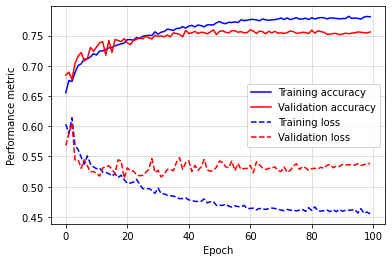

In [22]:
#plot the performance metrics of the network as a function of epoch
plt.plot(history.history['accuracy'], label='Training accuracy', c ='b')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy', c='r')
plt.plot(history.history['loss'], label='Training loss', c='b', ls ='--')
plt.plot(history.history['val_loss'], label = 'Validation loss', c='r', ls = '--')
plt.xlabel('Epoch')
plt.ylabel('Performance metric')
plt.grid(alpha = 0.5)
#plt.ylim([0.5, 1])
plt.legend()#loc='lower right')

test_loss, test_acc = model.evaluate(test_features,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

Now a new data set is generated and fed into the trained network for classification, prediction analysis, and ROC plotting. A trained network can be loaded at this stage and therefore bypass the previous data generation and network training code.

In [23]:
# from tensorflow import keras
# model = keras.models.load_model('final_train_out_T_obs_with_glitch-50k')

In [24]:
def artifact_model(t, t_c): #can teak the parameters of the glitch here
    A_0 = np.array(np.random.uniform(0.5e-18, 1.5e-18))
    phi_0 = np.array(np.random.uniform(0, np.pi))
    f_glitch = np.array(np.random.uniform(1e-5, 1e-1))
    #print(f' Glitch frequency {f_glitch}')
    w = 2 * np.pi * f_glitch
    tau_glitch = 1/f_glitch
    scale =  np.array(np.random.uniform(1e3, 1e5))
    output = A_0 * np.sin((w*t) + phi_0) * np.exp(-(t-t_c)**2/(2*np.pi*tau_glitch**2)/scale) #t_c/3 to ensure t_c<t

    return output

In [25]:
m_chirp_min = np.log10(m_chirp) #can tweak the paramters of chirp mass and luminsoity distance here 
m_chirp_max = np.log10(m_chirp*10)

D_L_min = np.log10(D_L)
D_L_max = np.log10(D_L*10)

In [26]:
%%time
def test_data_generator(ch1_dtype, ch2_dtype, n_masses = 10):
    ''' generate new unseen data for both channels to be evaluated by the network '''
    ch1_features = []
    ch1_labels = []
    ch1_SNRs = []
    ch1_chirp_masses = []
    ch1_luminosity_distances = []
    
    ch2_features = []
    ch2_labels = []
    ch2_SNRs = []
    ch2_chirp_masses = []
    ch2_luminosity_distances = []
    
    coalescence_times = []
    
    t = np.linspace(delta_t, T_obs, int(N_t))

    for i in range(n_masses):
        m_chirp_rand = 10**np.random.uniform(m_chirp_min, m_chirp_max)
        D_L_rand = 10**np.random.uniform(D_L_min, D_L_max)
        
        theta_l_bar = random.uniform(0, 2*np.pi)
        phi_l_bar =  random.uniform(0, 2*np.pi)
        theta_s_bar =  random.uniform(0, 2*np.pi)
        phi_s_bar =  random.uniform(0, 2*np.pi)
        
        t_c_max_val = t_c_max(f_min, m_chirp_rand, T_obs)
        #t_c = random.uniform(T_seg, T_obs)
        if random.randint(0, 1) == 0: #half values in T_obs
            t_c = random.uniform(T_seg, T_obs)
        else:
            t_c = random.uniform(T_obs, t_c_max_val)
        #t_c = random.uniform(T_obs, t_c_max_val)
                                 
        f_isco = 1/(np.pi * 6**(3/2) * 2**(6/5) * m_chirp_rand)
        t_isco = t_c - 5 * (8*np.pi*f_isco)**(-8/3) * m_chirp_rand**(-5/3)
        
        #integration limits
        lower = np.maximum(f_min, frequency(delta_t, t_c, m_chirp_rand))
        if t_isco > T_obs:
            upper = frequency(T_obs, t_c, m_chirp_rand)
        else:
            upper = f_isco
            
        f_noise = np.linspace(f_min, f_max, int(N_f)) 
        
        coalescence_times.append(t_c)
        
        if ch1_dtype == 'signal':
            ch1_chirp_masses.append(m_chirp_rand/m_solar)
            ch1_luminosity_distances.append(D_L_rand/(1e9*constants.parsec/constants.c))  

            ch1_SNR = np.sqrt(4*integrate.quad(integrand, lower, upper, args = (t_c, m_chirp_rand, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))[0])
            ch1_SNRs.append(ch1_SNR)

            ch1_noise_signal = get_noise(f_noise).T

            ch1_signal = h_func_t_piecewise(t, t_c, m_chirp_rand, t_isco, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar)
            ch1_ft_signal = fourier_transform(ch1_signal, N_perseg, delta_t, ch1_noise_signal)
            ch1_scaled_ft_signal = np.abs(np.add(ch1_ft_signal, ch1_noise_signal))/ np.amax(np.abs(np.add(ch1_ft_signal, ch1_noise_signal)))
            ch1_features.append(ch1_scaled_ft_signal**2)
            ch1_labels.append(0)
        elif ch1_dtype == 'signal + artifact':
            ch1_chirp_masses.append(m_chirp_rand/m_solar)
            ch1_luminosity_distances.append(D_L_rand/(1e9*constants.parsec/constants.c))

            ch1_SNR = np.sqrt(4*integrate.quad(integrand, lower, upper, args = (t_c, m_chirp_rand, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))[0])
            ch1_SNRs.append(ch1_SNR)

            ch1_noise_signal_artifact = get_noise(f_noise).T

            ch1_signal = h_func_t_piecewise(t, t_c, m_chirp_rand, t_isco, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar)
            ch1_ft_signal = fourier_transform(ch1_signal, N_perseg, delta_t, ch1_noise_signal_artifact)
            ch1_artifact = artifact_model(t, t_c)
            ch1_ft_artifact = fourier_transform(ch1_artifact, N_perseg, delta_t, ch1_noise_signal_artifact)

            ch1_ft_signal_2part = np.add(ch1_ft_signal, ch1_noise_signal_artifact)
            ch1_scaled_ft_signal_3part = np.abs(np.add(ch1_ft_signal_2part, ch1_ft_artifact))\
            / np.amax(np.abs(np.add(ch1_ft_signal_2part, ch1_ft_artifact)))
            ch1_features.append(ch1_scaled_ft_signal_3part**2)
            ch1_labels.append(0)
        elif ch1_dtype == 'noise + artifact':
            ch1_noise_artifact = get_noise(f_noise).T
            
            ch1_artifact = artifact_model(t, t_c)
            ch1_ft_artifact = fourier_transform(ch1_artifact, N_perseg, delta_t, ch1_noise_artifact)
            ch1_scaled_ft_artifact = np.abs(np.add(ch1_ft_artifact, ch1_noise_artifact))/ np.amax(np.abs(np.add(ch1_ft_artifact, ch1_noise_artifact)))
            ch1_features.append(ch1_scaled_ft_artifact**2)
            ch1_labels.append(1)
        elif ch1_dtype == 'noise':
            ch1_noise = get_noise(f_noise).T
            ch1_scaled_noise = np.abs(ch1_noise) / np.amax(np.abs(ch1_noise))
            ch1_features.append(ch1_scaled_noise**2) 
            ch1_labels.append(1) 
        else:
            print('Channel 1 data type not accepted')
            
            
        if ch2_dtype == 'signal':
            ch2_chirp_masses.append(m_chirp_rand/m_solar)
            ch2_luminosity_distances.append(D_L_rand/(1e9*constants.parsec/constants.c))

            ch2_SNR = np.sqrt(4*integrate.quad(integrand2, lower, upper, args = (t_c, m_chirp_rand, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))[0])
            ch2_SNRs.append(ch2_SNR)

            ch2_noise_signal = get_noise(f_noise).T

            ch2_signal = h_func_t_piecewise2(t, t_c, m_chirp_rand, t_isco, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar)
            ch2_ft_signal = fourier_transform(ch2_signal, N_perseg, delta_t, ch2_noise_signal)
            ch2_scaled_ft_signal = np.abs(np.add(ch2_ft_signal, ch2_noise_signal))/ np.amax(np.abs(np.add(ch2_ft_signal, ch2_noise_signal)))
            ch2_features.append(ch2_scaled_ft_signal**2)
            ch2_labels.append(0)
        elif ch2_dtype == 'signal + artifact':
            ch2_chirp_masses.append(m_chirp_rand/m_solar)
            ch2_luminosity_distances.append(D_L_rand/(1e9*constants.parsec/constants.c))

            ch2_SNR = np.sqrt(4*integrate.quad(integrand2, lower, upper, args = (t_c, m_chirp_rand, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar))[0])
            ch2_SNRs.append(ch2_SNR)
            ch2_noise_signal_artifact = get_noise(f_noise).T

            ch2_signal = h_func_t_piecewise2(t, t_c, m_chirp_rand, t_isco, D_L_rand, theta_s_bar, phi_s_bar, theta_l_bar, phi_l_bar)
            ch2_ft_signal = fourier_transform(ch2_signal, N_perseg, delta_t, ch2_noise_signal_artifact)

            ch2_artifact = artifact_model(t, t_c)
            ch2_ft_artifact = fourier_transform(ch2_artifact, N_perseg, delta_t, ch2_noise_signal_artifact)

            ch2_ft_signal_2part = np.add(ch2_ft_signal, ch2_noise_signal_artifact)
            ch2_scaled_ft_signal_3part = np.abs(np.add(ch2_ft_signal_2part, ch2_ft_artifact))\
            / np.amax(np.abs(np.add(ch2_ft_signal_2part, ch2_ft_artifact)))
            ch2_features.append(ch2_scaled_ft_signal_3part**2)
            ch2_labels.append(0)
            
        elif ch2_dtype == 'noise + artifact':
            ch2_noise_artifact = get_noise(f_noise).T
            
            ch2_artifact = artifact_model(t, t_c)
            ch2_ft_artifact = fourier_transform(ch2_artifact, N_perseg, delta_t, ch2_noise_artifact)
            ch2_scaled_ft_artifact = np.abs(np.add(ch2_ft_artifact, ch2_noise_artifact))/ np.amax(np.abs(np.add(ch2_ft_artifact, ch2_noise_artifact)))
            ch2_features.append(ch2_scaled_ft_artifact**2)
            ch2_labels.append(1)
        elif ch2_dtype == 'noise':
            ch2_noise = get_noise(f_noise).T
            ch2_scaled_noise = np.abs(ch2_noise) / np.amax(np.abs(ch2_noise))
            ch2_features.append(ch2_scaled_noise**2) 
            ch2_labels.append(1) 
        else:
            print('Channel 2 data type not accepted')
            
    return np.array(ch1_features), np.array(ch1_labels), ch1_SNRs, ch1_chirp_masses, ch1_luminosity_distances,\
np.array(ch2_features), np.array(ch2_labels), ch2_SNRs, ch2_chirp_masses, ch2_luminosity_distances, np.array(coalescence_times)#maybe need to make these arrays
            
ch1_features, ch1_labels, ch1_SNRs, ch1_chirp_masses, ch1_luminosity_distances,\
ch2_features, ch2_labels, ch2_SNRs, ch2_chirp_masses, ch2_luminosity_distances,\
coalescence_times = test_data_generator('signal + artifact', 'signal', 5000) #here the type of data and number of samples is chosen (5000 used for the report)

CPU times: user 6min 24s, sys: 8.83 s, total: 6min 33s
Wall time: 6min 34s


In [27]:
ch1_features = image_resizer(ch1_features)
ch2_features = image_resizer(ch2_features)

(5000, 1000, 100, 1)
(5000, 1000, 100, 1)


In [28]:
model.evaluate(ch1_features,  ch1_labels, verbose=2) #performance of the network
model.evaluate(ch2_features,  ch2_labels, verbose=2)

157/157 - 1s - loss: 0.2019 - accuracy: 0.8392 - 710ms/epoch - 5ms/step
157/157 - 1s - loss: 0.2135 - accuracy: 0.8326 - 675ms/epoch - 4ms/step


[0.21354854106903076, 0.8325999975204468]

In [29]:
ch1_predictions = model.predict(ch1_features)
ch1_classifications = np.argmax(ch1_predictions, axis=1)

ch2_predictions = model.predict(ch2_features)
ch2_classifications = np.argmax(ch2_predictions, axis=1)

In [30]:
def cross_checker(ch1_classifications, ch2_classifications):
    ''' checks the concordant classifications for each channel '''
    cross_check = [] 
    correct = 0
    for i in range(len(ch1_classifications)):

        if ch1_classifications[i] == ch2_classifications[i]:
            cross_check.append('True')
            correct += 1
        else:
            cross_check.append('False')     

    #print(cross_check)
    print(f'cross check percentage {correct/len(ch1_classifications)*100:.2f}%')
    return cross_check

cross_check = cross_checker(ch1_classifications, ch2_classifications)

cross check percentage 91.50%


In [31]:
ch1_percentages = percentages_of_signals(ch1_labels, ch1_predictions)
ch2_percentages = percentages_of_signals(ch2_labels, ch2_predictions)

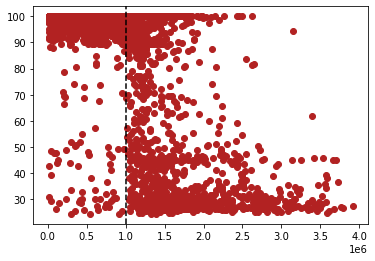

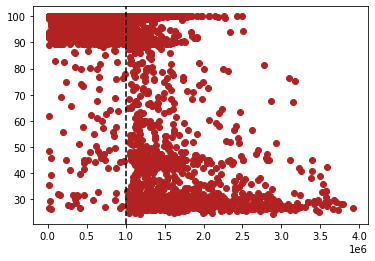

In [32]:
plt.scatter(coalescence_times, ch1_percentages, color = 'firebrick')
plt.axvline(T_obs, color = 'black',  linestyle='--')
plt.show()

plt.scatter(coalescence_times, ch2_percentages, color = 'firebrick')
plt.axvline(T_obs, color = 'black',  linestyle='--')
plt.show()

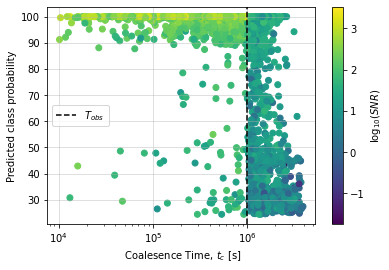

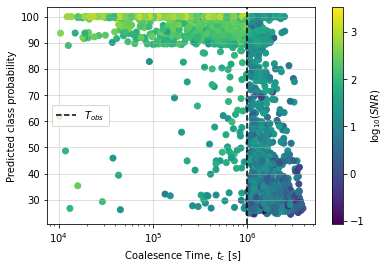

In [33]:
plt.scatter(coalescence_times, ch1_percentages, c = np.log10(ch1_SNRs))
plt.axvline(T_obs, color = 'black',  linestyle='--', label = r"$T_{obs}$")
plt.colorbar(label = r"$\log_{10}(SNR)$")
plt.grid(alpha = 0.5)
#plt.title('Channel 1 detector')
plt.xlabel(r" Coalesence Time, $t_c$ [s]")
plt.ylabel('Predicted class probability')
plt.xscale('log')
plt.legend()
plt.show()

plt.scatter(coalescence_times, ch2_percentages, c = np.log10(ch2_SNRs))
plt.axvline(T_obs, color = 'black',  linestyle='--', label = r"$T_{obs}$")
plt.colorbar(label = r"$\log_{10}(SNR)$")
plt.grid(alpha = 0.5)
#plt.title('Channel 2 detector')
plt.xlabel(r" Coalesence Time, $t_c$ [s]")
plt.ylabel('Predicted class probability')
plt.xscale('log')
plt.legend()
plt.show()

Following analysis code only works on signal data as noise data does not depend on binary parameters

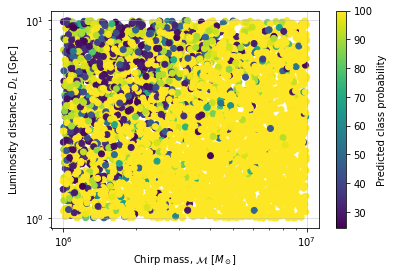

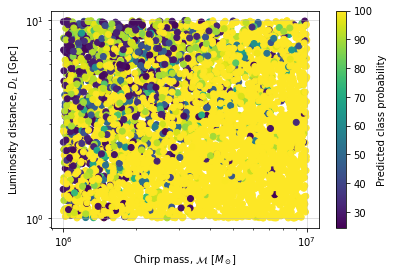

In [34]:
plt.scatter(ch1_chirp_masses, ch1_luminosity_distances, c=ch1_percentages)
#plt.title('Channel 1 Detector')
plt.xlabel(r"Chirp mass, $\mathcal{M}$ $[M_\odot]$")
plt.ylabel(r"Luminosity distance, $D_L$ [Gpc]")
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label = 'Predicted class probability')
plt.grid(alpha = 0.5)
plt.show()

plt.scatter(ch2_chirp_masses, ch2_luminosity_distances, c=ch2_percentages)
#plt.title('Channel 2 Detector')
plt.xlabel(r"Chirp mass, $\mathcal{M}$ $[M_\odot]$")
plt.ylabel(r"Luminosity distance, $D_L$ [Gpc]")
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label = 'Predicted class probability')
plt.grid(alpha = 0.5)
plt.show()

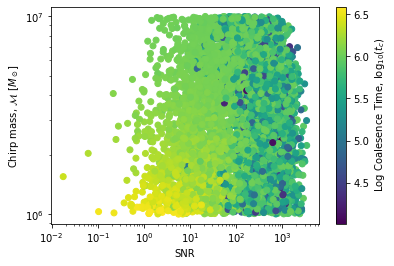

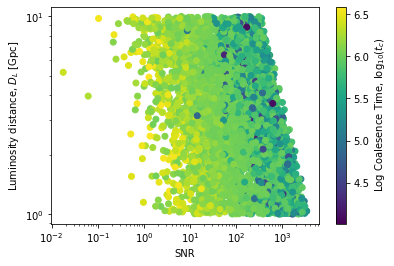

In [35]:
plt.scatter(ch1_SNRs, ch1_chirp_masses, c = np.log10(coalescence_times))
plt.ylabel(r"Chirp mass, $\mathcal{M}$ $[M_\odot]$")
plt.xlabel('SNR')
plt.loglog()
plt.colorbar(label = r" Log Coalesence Time, $\log_{10}(t_c)$ ")
plt.show()

plt.scatter(ch1_SNRs, ch1_luminosity_distances, c = np.log10(coalescence_times))
plt.ylabel(r"Luminosity distance, $D_L$ [Gpc]")
plt.xlabel('SNR')
plt.loglog()
plt.colorbar(label = r" Log Coalesence Time, $\log_{10}(t_c)$ ")
plt.show()

The following code will fail if an inadequate number of data samples is generated, as this would result in empty bins.

In [72]:
from scipy import stats
def binner(SNRs, percentages, bins = 30):
    ''' statistically bins data using median binning and a logarithmic scale'''
    binned_data = stats.binned_statistic(np.log10(SNRs), percentages, statistic='median', bins = bins)
    return binned_data[0], binned_data[1]#, bins

ch1_binned, ch1_bins = binner(ch1_SNRs, ch1_percentages)
ch2_binned, ch2_bins = binner(ch2_SNRs, ch2_percentages)

ch1_bins give the bin edges, we want to plot value against middle of the bins.

In [73]:
def bin_mid_finder(binned, bins): #used for plotting later
    ''' finds the midpoint of each bin '''
    bin_mids = []
    for i in range(len(binned)):
        bin_mids.append((bins[i] + bins[i+1])/2)

    return np.array(bin_mids)

ch1_bin_mids =  bin_mid_finder(ch1_binned, ch1_bins)
ch2_bin_mids =  bin_mid_finder(ch2_binned, ch2_bins)

In [74]:
def bin_width_finder(binned, bins): #used for plotting later
    ''' finds the width of each bin '''
    bin_widths = []
    for i in range(len(binned)):
        bin_widths.append((-10**bins[i] + 10**bins[i+1]))

    return np.array(bin_widths)

ch1_bin_widths =  bin_width_finder(ch1_binned, ch1_bins)
ch2_bin_widths =  bin_width_finder(ch2_binned, ch2_bins)

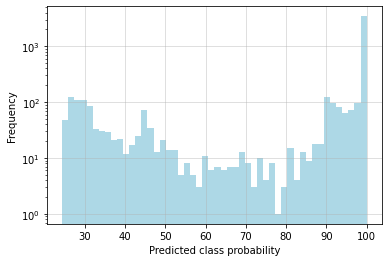

In [75]:
hx, hy, _ = plt.hist(ch1_percentages, bins=50, color="lightblue") #distribution of predicted class porbability
plt.grid(alpha = 0.5)
#plt.title('Probability distirbution in data set')
plt.yscale('log')
plt.xlabel('Predicted class probability')
plt.ylabel('Frequency')
plt.show()

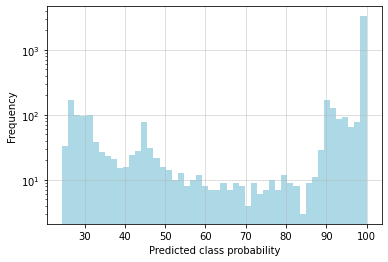

In [76]:
hx, hy, _ = plt.hist(ch2_percentages, bins=50, color="lightblue")
plt.grid(alpha = 0.5)
#plt.title('Probability distirbution in data set')
plt.yscale('log')
plt.xlabel('Predicted class probability')
plt.ylabel('Frequency')
plt.show()

In [77]:
import scipy.stats as st 

In [78]:
def percentile_interval(pi, number_bins, SNRs, bins, percentages):
    ''' calculate percentile invervals of the binned data '''
    lower_pi = []
    upper_pi = []
    bin_histogram = []
    for j in range(number_bins):
        percentages_in_1_bin = []
        SNRs_in_1_bin = []
        for i in range(len(SNRs)): #this avoids rounding errors
            if np.log10(SNRs[i]) >= bins[j] and np.log10(SNRs[i]) < bins[j + 1]:
                percentages_in_1_bin.append(percentages[i])
                SNRs_in_1_bin.append(SNRs[i])
                
        bin_histogram.append(len(percentages_in_1_bin))
        lower, upper = np.percentile(percentages_in_1_bin, [(100 - pi)/2, (100 - pi)/2 + pi])
        lower_pi.append(lower)
        upper_pi.append(upper)
        #print(lower, med, upper)
        
    return upper_pi, lower_pi, bin_histogram

In [79]:
ch1_upper_pi_90, ch1_lower_pi_90, ch1_bin_histogram = percentile_interval(90, 30, ch1_SNRs, ch1_bins, ch1_percentages)
ch1_upper_pi_75, ch1_lower_pi_75, ch1_bin_histogram = percentile_interval(75, 30, ch1_SNRs, ch1_bins, ch1_percentages)
ch1_upper_pi_50, ch1_lower_pi_50, ch1_bin_histogram = percentile_interval(50, 30, ch1_SNRs, ch1_bins, ch1_percentages)

ch2_upper_pi_90, ch2_lower_pi_90, ch2_bin_histogram = percentile_interval(90, 30, ch2_SNRs, ch2_bins, ch2_percentages)
ch2_upper_pi_75, ch2_lower_pi_75, ch2_bin_histogram = percentile_interval(75, 30, ch2_SNRs, ch2_bins, ch2_percentages)
ch2_upper_pi_50, ch2_lower_pi_50, ch2_bin_histogram = percentile_interval(50, 30, ch2_SNRs, ch2_bins, ch2_percentages)

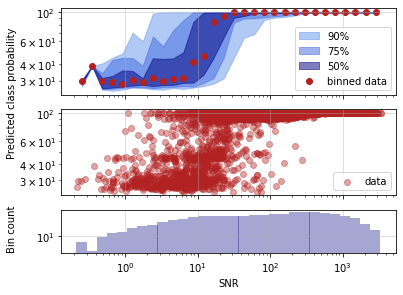

In [87]:
#plotting the sensitibty plot for the channel 1 detector
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(6,4.5), gridspec_kw={'height_ratios': [2, 2, 1]})

ax1.fill_between(10**ch1_bin_mids, ch1_lower_pi_90, ch1_upper_pi_90, alpha=0.5, label = '90%', color = 'cornflowerblue')
ax1.fill_between(10**ch1_bin_mids, ch1_lower_pi_75, ch1_upper_pi_75, alpha=0.5, label = '75%', color = 'royalblue')
ax1.fill_between(10**ch1_bin_mids, ch1_lower_pi_50, ch1_upper_pi_50, alpha=0.5, label = '50%', color = 'navy')
ax1.scatter(10**ch1_bin_mids, ch1_binned, label = 'binned data', color = 'firebrick')
#ax1.set_title('Statisticly binned SNR vs predicted class probability')
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_ylabel('Predicted class probability')
ax1.grid(alpha = 0.5)
ax1.legend(loc = 'lower right')
#ax1.legend(loc = 'upper left')

ax2.scatter(ch1_SNRs, ch1_percentages, color = 'firebrick', label = 'data', alpha = 0.4)
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.set_ylabel('Predicted class probability')
ax2.grid(alpha = 0.5)
#ax2.set_ylim(1,110)
ax2.legend(loc = 'lower right')

#ax2.fill_between(10**ch1_bin_mids, np.zeros(len(ch1_bin_mids)), ch1_bin_histogram, step = 'mid', alpha = 0.3, color = 'navy')
ax3.bar(10**ch1_bin_mids, ch1_bin_histogram, ch1_bin_widths, alpha = 0.35, color = 'navy')
#ax2.scatter(10**ch1_bin_mids, ch1_bin_histogram, color = 'firebrick')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('SNR')
#ax3.set_ylabel('Bin histogram')
ax3.grid(alpha = 0.5)

fig.align_ylabels()
#fig.text(-0.1, 0.62, 'Predicted class probability', va='center', rotation='vertical')
fig.text(0, 0.62, 'Predicted class probability', va='center', rotation='vertical')
fig.text(0, 0.2, 'Bin count', va='center', rotation='vertical')
fig.show()

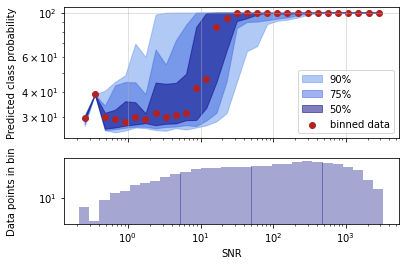

In [81]:
#same plot as before but without the data points shown
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax1.fill_between(10**ch1_bin_mids, ch1_lower_pi_90, ch1_upper_pi_90, alpha=0.5, label = '90%', color = 'cornflowerblue')
ax1.fill_between(10**ch1_bin_mids, ch1_lower_pi_75, ch1_upper_pi_75, alpha=0.5, label = '75%', color = 'royalblue')
ax1.fill_between(10**ch1_bin_mids, ch1_lower_pi_50, ch1_upper_pi_50, alpha=0.5, label = '50%', color = 'navy')
ax1.scatter(10**ch1_bin_mids, ch1_binned, label = 'binned data', color = 'firebrick')
#ax1.set_title('Statisticly binned SNR vs predicted class probability')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Predicted class probability')
ax1.grid(alpha = 0.5)
ax1.legend(loc = 'lower right')
#ax1.legend(loc = 'upper left')

ax2.bar(10**ch1_bin_mids, ch1_bin_histogram, ch1_bin_widths, alpha = 0.35, color = 'navy')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('SNR')
ax2.set_ylabel('Data points in bin')

fig.align_ylabels()
fig.show()

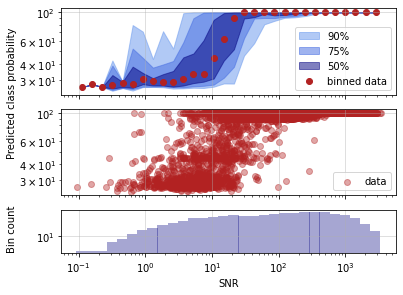

In [82]:
#plotting the sensitibty plot for the channel 1 detector
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(6,4.5), gridspec_kw={'height_ratios': [2, 2, 1]})

ax1.fill_between(10**ch2_bin_mids, ch2_lower_pi_90, ch2_upper_pi_90, alpha=0.5, label = '90%', color = 'cornflowerblue')
ax1.fill_between(10**ch2_bin_mids, ch2_lower_pi_75, ch2_upper_pi_75, alpha=0.5, label = '75%', color = 'royalblue')
ax1.fill_between(10**ch2_bin_mids, ch2_lower_pi_50, ch2_upper_pi_50, alpha=0.5, label = '50%', color = 'navy')
ax1.scatter(10**ch2_bin_mids, ch2_binned, label = 'binned data', color = 'firebrick')
#ax1.set_title('Statisticly binned SNR vs predicted class probability')
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_ylabel('Predicted class probability')
ax1.grid(alpha = 0.5)
ax1.legend(loc = 'lower right')
#ax1.legend(loc = 'upper left')

ax2.scatter(ch2_SNRs, ch2_percentages, color = 'firebrick', label = 'data', alpha = 0.4)
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.set_ylabel('Predicted class probability')
ax2.grid(alpha = 0.5)
ax2.legend(loc = 'lower right')

#ax2.fill_between(10**ch1_bin_mids, np.zeros(len(ch1_bin_mids)), ch1_bin_histogram, step = 'mid', alpha = 0.3, color = 'navy')
ax3.bar(10**ch2_bin_mids, ch2_bin_histogram, ch2_bin_widths, alpha = 0.35, color = 'navy')
#ax2.scatter(10**ch1_bin_mids, ch1_bin_histogram, color = 'firebrick')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('SNR')
#ax3.set_ylabel('Bin histogram')
ax3.grid(alpha = 0.5)


fig.align_ylabels()
fig.text(0, 0.62, 'Predicted class probability', va='center', rotation='vertical')
fig.text(0, 0.2, 'Bin count', va='center', rotation='vertical')
fig.show()

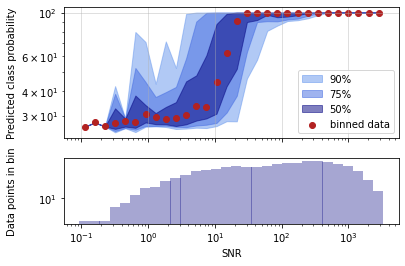

In [83]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax1.fill_between(10**ch2_bin_mids, ch2_lower_pi_90, ch2_upper_pi_90, alpha=0.5, label = '90%', color = 'cornflowerblue')
ax1.fill_between(10**ch2_bin_mids, ch2_lower_pi_75, ch2_upper_pi_75, alpha=0.5, label = '75%', color = 'royalblue')
ax1.fill_between(10**ch2_bin_mids, ch2_lower_pi_50, ch2_upper_pi_50, alpha=0.5, label = '50%', color = 'navy')
ax1.scatter(10**ch2_bin_mids, ch2_binned, label = 'binned data', color = 'firebrick')
#ax1.set_title('Statisticly binned SNR vs predicted class probability')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Predicted class probability')
ax1.grid(alpha = 0.5)
ax1.legend(loc = 'lower right')
#ax1.legend(loc = 'upper left')

ax2.bar(10**ch2_bin_mids, ch2_bin_histogram, ch2_bin_widths, alpha = 0.35, color = 'navy')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('SNR')
ax2.set_ylabel('Data points in bin')

fig.align_ylabels()
fig.show()

In [84]:
ch1_bins = ch1_bin_mids #short term fix, this needs to be properly replaced
ch2_bins = ch2_bin_mids

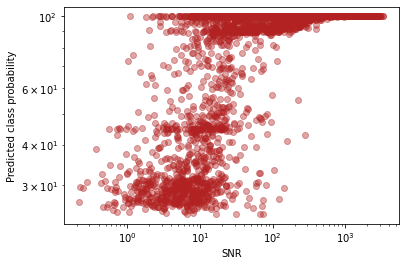

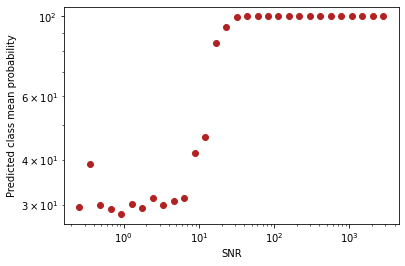

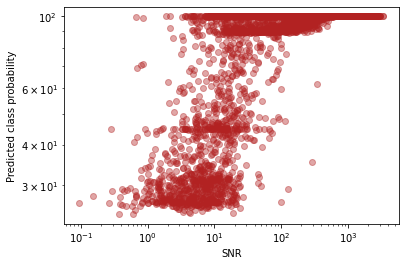

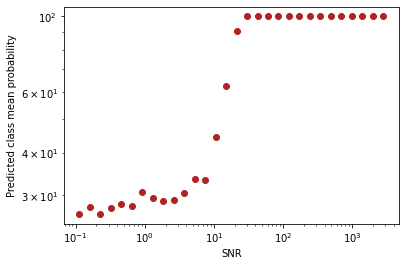

In [85]:
#seperate data points and binned data points form previous sensitivty plots
#plt.title('SNR vs predicted class probability')
plt.scatter(ch1_SNRs, ch1_percentages, color = 'firebrick', alpha = 0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('Predicted class probability')
plt.show()

#plt.title('Statistically binned SNR vs predicted class probability')
plt.scatter(10**ch1_bins, ch1_binned, color = 'firebrick')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('Predicted class mean probability')
plt.show()

#plt.title('SNR vs predicted class probability')
plt.scatter(ch2_SNRs, ch2_percentages, color = 'firebrick', alpha = 0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('Predicted class probability')
plt.show()

#plt.title('Statistically binned SNR vs predicted class probability')
plt.scatter(10**ch2_bins, ch2_binned, color = 'firebrick')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('Predicted class mean probability')
plt.show()

In [86]:
#percentiles of raw and binned data
print(np.percentile(ch1_percentages, [25, 50, 75]))
print(np.percentile(ch1_binned, [25, 50, 75]))

print(np.percentile(ch2_percentages, [25, 50, 75]))
print(np.percentile(ch2_binned, [25, 50, 75]))

[ 92.55354404 100.         100.        ]
[ 30.84085137  96.69698477 100.        ]
[ 90.91931581 100.         100.        ]
[ 29.2099718   76.80543363 100.        ]
